### Import necessary modules

In [4]:
import os # for dealing with directories
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import pandas as pd # for working with dataframes
import matplotlib.pyplot as plt # for plotting
import matplotlib # for color maps
import numpy as np # for arrays
from sklearn.decomposition import PCA # for PCA for normalization
from ect import ECT, EmbeddedGraph # for calculating ECTs

______
# Leaves
_______

The leaf shape data can be downloaded from [Modified leaf shape contour data](https://figshare.com/articles/dataset/Modified_leaf_shape_contour_data/25435936) (Wang, Willey, and Chitwood, 2024). Each subfolder should be unzipped and the overall folder named `2017_leaves` to be compatible with the code below.


**Reference**:
Wang, Elena; Willey, Nathan; Chitwood, Dan (2024). Modified leaf shape contour data. figshare. Dataset. https://doi.org/10.6084/m9.figshare.25435936.v1

### Define leaf datasets and groups

We will only work with the `Leafsnap` and `Transect` datasets (because they contain leaves from diverse groups, unlike the other datasets), but the code below will parse the entire folder structure to create group identities for leaves.

In [5]:
# a list of folder directories of datasets to analyze
datasets = ["Alstroemeria",
            "Apple",
            "Arabidopsis",
            "Arabidopsis_asymmetry",
            "Brassica/napus",
            "Brassica/rapa",
            "Coleus/Co1",
            "Coleus/Co2",
            "Coleus/Co3",
            "Coleus/Co4",
            "Coleus/Co5",
            "Coleus/Co6",
            "Cotton",
            "Grape/Domesticated_grape/GrapeJune1.2011",
            "Grape/Domesticated_grape/GrapeMay28.2011",
            "Grape/Domesticated_grape/GrapeMay29.2011",
            "Grape/Domesticated_grape/GrapeMay30.2011",
            "Grape/Domesticated_grape/GrapeMay31.2011",
            "Grape/Geneva_2013/Folder1_Jose",
            "Grape/Geneva_2013/Folder2_Tommy",
            "Grape/Geneva_2013/Folder3_Danny",
            "Grape/Geneva_2013/Folder4_Quaneisha",
            "Grape/Geneva_2013/Folder5_Susan",
            "Grape/Geneva_2013/Folder6_Darren",
            "Grape/Geneva_2013/Folder7_Jose2",
            "Grape/Geneva_2013/Folder8_Susan2",
            "Grape/Geneva_2013/Folder9_Tommy2",
            "Grape/Geneva_2013/Folder10_Quaneisha2",
            "Grape/Geneva_2013/Folder11_Darren2",
            "Grape/Geneva_2013/Folder12_Danny",
            "Grape/Geneva_2015/060815",
            "Grape/Geneva_2015/060915",
            "Grape/Geneva_2015/061015",
            "Grape/Geneva_2016/Dan_Geneva_2016",
            "Grape/Geneva_2016/MF_Geneva_2016",
            "Grape/MtVernon_scans/2014_MtVernon_Scans",
            "Grape/MtVernon_scans/2016_MtVernon_Scans",
            "Grass",
            "Ivy",
            "Leafsnap",
            "Passiflora",
            "Pepper",
            "Potato",
            "Tomato_asymmetry",
            "Tomato_BILs/B1",
            "Tomato_BILs/B2",
            "Tomato_BILs/B3",
            "Tomato_chamber/C1",
            "Tomato_chamber/C2",
            "Tomato_chamber/C3",
            "Tomato_chamber/C4",
            "Tomato_chamber/C5",
            "Tomato_entire",
            "Tomato_field/F1",
            "Tomato_field/F2",
            "Tomato_wild/WA",
            "Tomato_wild/WB",
            "Transect/Batch_1_W",
            "Transect/Batch_2_B",
            "Viburnum/V1",
            "Viburnum/V2",
           ]

# make a list of overall groups
groups = [] # store group names

for i in datasets: # for each dataset

    if ("Tomato" in i) & ("/" in i):
        groups.append(i[:i.index('_')]) # then only take up to the underscore
    
    elif "/" in i: # if there are subfolders
        groups.append(i[:i.index('/')]) # then only take the name of the first folder
    elif "_" in i: # if there is a redundant folder with "_" like Arabidopsis
        groups.append(i[:i.index('_')]) # then only take up to the underscore
    else:
        groups.append(i) # otherwise just take the whole name

### Create a dataframe of all leaf files

We will create an overall dataframe with paths and metadata for each leaf.

In [6]:
file_names = [] # store file names
dataset = [] # store dataset names
group = [] # store group names

for i in range(len(datasets)): # for each dataset
    
    curr_dataset = datasets[i] # get current dataset
    curr_group = groups[i] # get current group
    data_dir = "./2017_leaves/"+curr_dataset+"/" # set data directory
    files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
    #file_names.remove('.DS_Store') # remove .DS_Store file
    files.sort() # sort the list of file names

    for j in range(len(files)): # for each file
        
        file_names.append("./2017_leaves/"+curr_dataset+"/"+files[j]) # store file names
        dataset.append(curr_dataset) # store datasets
        group.append(curr_group) # store group
        
# create a pandas dataframe of all file info
lf_df = pd.DataFrame(
    {"group":group,
     "dataset":dataset,
     "file":file_names,
    })

# print out number of each dataset
lf_df["group"].value_counts()

group
Tomato          82034
Coleus          34607
Grape           11379
Apple            9619
Transect         5808
Arabidopsis      5101
Leafsnap         4565
Passiflora       3298
Pepper           3277
Cotton           2885
Viburnum         2422
Alstroemeria     2392
Potato           1840
Brassica         1832
Grass             866
Ivy               865
Name: count, dtype: int64

### Calculate leaf ECTs

We only want to analyze leaves from the `Leafsnap` and `Transect` datasets. We first mask the overall dataframe for these datasets. Then, we select random leaves to visualize.

In [7]:
rand_num = 40 # set number of random leaves to visualize
rand_state = 42 # set the random state

# analyze only Transect or LeafSnap datasets to maximize the diverse leaf shape analyzed
just_diverse_lfs = lf_df[(lf_df["group"]=="Transect") | (lf_df["group"]=="Leafsnap")]
rand_df = just_diverse_lfs.sample(n=rand_num, random_state=rand_state) # select random leaves


We next calculate ECT images for the desired leaf shapes and store to an array.

In [8]:
num_dir=360 # set number of directional axes
num_thresh=360 # set number of thresholds each axis

# create array to store ECT outputs
# number of ECTs x num directional axes x number of thresholds
ect_lf_arr = np.zeros((len(rand_df),num_dir,num_thresh))

for i in range(len(rand_df)): # for each shape

    shape = np.load(rand_df["file"].iloc[i]) # get the current shape
    print(i, rand_df["file"].iloc[i])

    G = EmbeddedGraph() # initiate a graph
    G.add_cycle(shape) # create graph from shape
    G.set_PCA_coordinates( center_type='min_max', scale_radius=1) # perform PCA and normalize
    myect = ECT(num_dirs = num_dir, num_thresh=num_thresh) # calculate ECT
    myect.set_bounding_radius(1) # set bounding radius
    ect_lf_arr[i,:,:] = myect.calculateECT(G) # retrieve ECT


0 ./2017_leaves/Leafsnap/cornus_mas_ny1113_08_4.npy
1 ./2017_leaves/Leafsnap/celtis_tenuifolia_wb1593_02_4.npy
2 ./2017_leaves/Leafsnap/betula_nigra_wb1038_07_4.npy
3 ./2017_leaves/Leafsnap/populus_grandidentata_wb1210_09_4.npy
4 ./2017_leaves/Transect/Batch_2_B/Yakusugi_800m_Lindera_erythrocarpa_z4.npy
5 ./2017_leaves/Leafsnap/malus_hupehensis_ny1051_13_4.npy
6 ./2017_leaves/Transect/Batch_1_W/Danum_Valley_Field_Center_Luvunga_heterophylla_84b__z68.npy
7 ./2017_leaves/Transect/Batch_1_W/Danum_Valley_Field_Center_Octomeles_sumatrana_1_25__z79.npy
8 ./2017_leaves/Leafsnap/asimina_triloba_pi2178_06_4.npy
9 ./2017_leaves/Transect/Batch_1_W/Danum_Valley_Field_Center_Payena_acuminata_1_96b__z6.npy
10 ./2017_leaves/Transect/Batch_2_B/Borinquen_Croton_betulinus_3352_z2.npy
11 ./2017_leaves/Leafsnap/abies_concolor_ny1178_06_4.npy
12 ./2017_leaves/Leafsnap/amelanchier_arborea_pi2410_05_4.npy
13 ./2017_leaves/Leafsnap/ilex_opaca_pi2490_08_4.npy
14 ./2017_leaves/Transect/Batch_2_B/Clearwater_WA_S

We create a list of species name to display in the plot associated with each leaf.

In [7]:
lf_names = ["Cornus mas",
"Celtis tenuifolia",
"Betula nigra",
"Populus grandidentata",
"Lindera erythrocarpa",
"Malus hupehensis",
"Luvunga heterophylla",
"Octomeles sumatrana",
"Asimina triloba",
"Payena acuminata",
"Croton betulinus",
"Abies concolor",
"Amelanchier arborea",
"Ilex opaca",
"Salix lascandia",
"Amelanchier canadensis",
"Platanus acerifolia",
"Carya tomentosa",
"Betula alleghaniensis",
"Cyrilla racemiflora",
"Chionanthus virginicus",
"Prunus sargentii",
"Cercidiphyllum japonicum",
"Quercus acutissima",
"Quercus montana",
"Abies concolor",
"Quercus nigra",
"Ardisia quinquegona",
"Carpinus betulus",
"Salix sp.",
"Dryobalanopsis lanceolata",
"Hopea nervosa",
"Ziziphus angustifolius",
"Fagus grandifolia",
"Prunus pensylvanica",
"Tsuga canadensis",
"Salix nigra",
"Popowia pisocarpa",
"Morus rubra",
"Hopea sangal"]

### Plot leaves next to ECTs

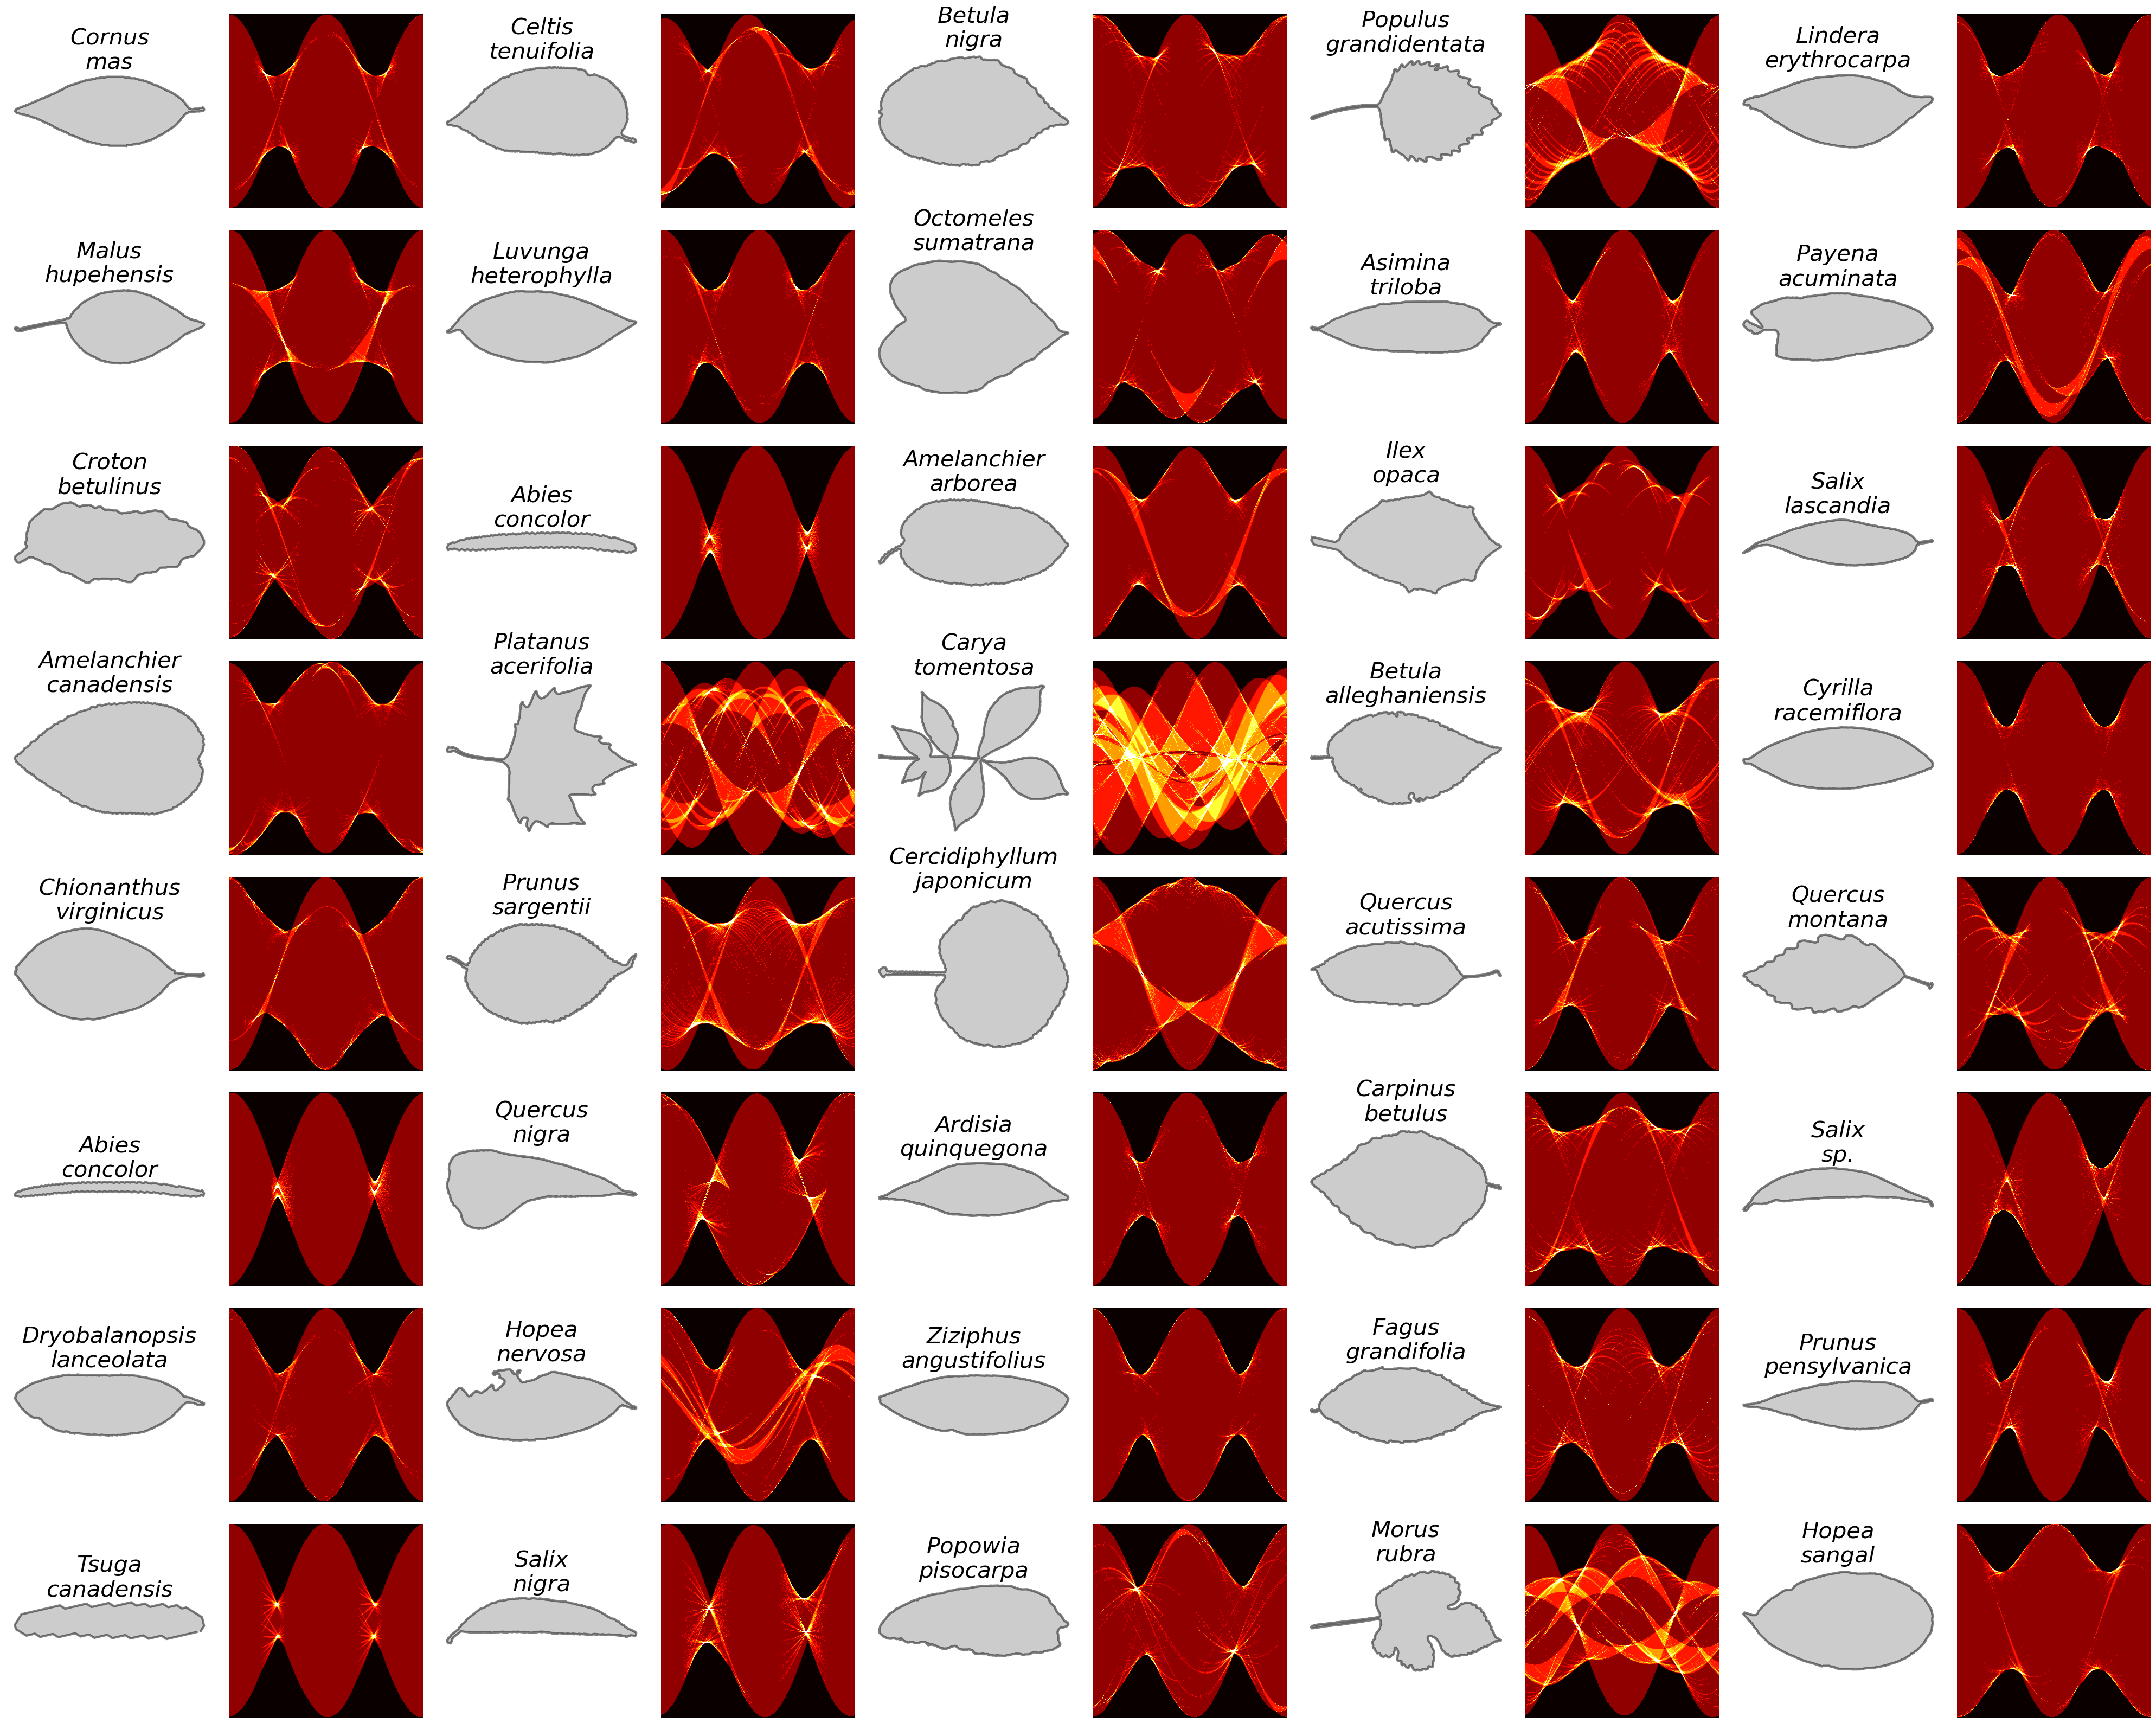

In [65]:
plot_count = 1 # counter for plt.subplot
ect_count = 0 # counter for ECT index
plt.figure(figsize=(40,32))

for i in rand_df.index: # for each of the randomly chosen indices
    
    plt.subplot(8,10,plot_count)
    curr_file = rand_df["file"][i] # get current file
    curr_leaf = np.load(curr_file) # load current leaf
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(curr_leaf) # fit PCA to leaf data to find longest axis
    pca_scores = pca.transform(curr_leaf) # retrieve PCA scores of leaf
    plt.plot(pca_scores[:,0], pca_scores[:,1], lw=3, c="k", alpha=0.5)
    plt.fill(pca_scores[:,0], pca_scores[:,1], lw=0, c="k", alpha=0.2)
    plt.title(lf_names[ect_count][:lf_names[ect_count].index(" ")] + "\n" + lf_names[ect_count][lf_names[ect_count].index(" ")+1:], 
              fontsize=30, fontstyle="italic")
    plt.axis("off")
    plt.gca().set_aspect("equal")
    
    plot_count+=1
    
    plt.subplot(8,10,plot_count)

    colormap =plt.cm.hot
    normalize = matplotlib.colors.Normalize(vmin=0, vmax=5)

    plt.imshow(ect_lf_arr[ect_count].T, cmap=colormap, norm=normalize)
    plt.axis("off")
    plt.gca().set_aspect("equal")

    ect_count+=1
    
    plot_count+=1
    
plt.tight_layout()

______
# Pavement cells
_______

The following pavement cell shapes collected from across plants is from the following publication:

Róza V. Vőfély, Joseph Gallagher, Grace D. Pisano, Madelaine Bartlett, Siobhan A. Braybrook (2019) [**Of puzzles and pavements: a quantitative exploration of leaf epidermal cell shape**](https://doi.org/10.1111/nph.15461), *New Phytologist* 221(1):540-552.

The data is available on [Dryad](https://datadryad.org/stash/dataset/doi:10.5061/dryad.g4q6pv3). In order to run the code below, you will need to download the cell outlines stored as `.txt` files in the `CellCoordinates.zip` folder (19.61MB). Please use the `SampleTable.csv` file in this GitHub repo, with sample names used to generate paths to pavement cell shapes and associated metadata, to execute the code below.

In [10]:
cell_df = pd.read_csv("./SampleTable.csv", encoding='unicode_escape') # read in data

cell_df.drop(cell_df[cell_df["Sample_Number"]=="gp15-104-22"].index, inplace=True) # drop sample
cell_df.drop(cell_df[cell_df["Sample_Number"]=="JH15-010-ad-6"].index, inplace=True) # drop sample

Generate counts for major taxanomic groups.

In [11]:
cell_df["Major Clade"].value_counts() # value counts for Major Clade

Major Clade
eudicots                       6548
ferns                          2175
monocots                       1844
gymnosperms                     570
early_diverging_angiosperms     209
Name: count, dtype: int64

Downsample the major taxonomic groups to the least largest group, for even representation.

In [12]:
downsample = True # do you want to downsample, True or False
rand_num = 209 # select number to randomly sample
df_list = [] # a list to store pandas dataframes
rand_state = 42 # set the random state

if downsample==False:
    rand_df = cell_df

else:
    for i in cell_df["Major Clade"].unique(): # for each group
        curr_group = cell_df[cell_df["Major Clade"]==i] # select all samples of current group
        df_list.append(curr_group.sample(n=rand_num, random_state=rand_state)) # select random rows for the current group
        
    rand_df = pd.concat(df_list).reset_index() # concatenate list of dataframes together

print(len(rand_df)) # print the overall length of the selected cells

1045


From the downsampled dataset, select the number of random pavement cells to visualize.

In [13]:
rand_num = 40 # set number of random cells to visualize
rand_state = 42 # set the random state

rand_df = rand_df.sample(n=rand_num, random_state=rand_state) # select random cells

### Calculate pavement cell ECTs

Calcualte ECT images for the desired pavement cell shapes.

In [14]:
num_dir=360 # set number of directional axes
num_thresh=360 # set number of thresholds each axis

# create array to store ECT outputs
# number of ECTs x num directional axes x number of thresholds
ect_cell_arr = np.zeros((len(rand_df),num_dir,num_thresh))

for i in range(len(rand_df)): # for each shape

    shape = np.loadtxt("./CellCoordinates/"+str(rand_df["Sample_Number"].iloc[i])+".txt",skiprows=1) # get the current shape
    print(i, rand_df["Name_submitted"].iloc[i])

    G = EmbeddedGraph() # initiate a graph
    G.add_cycle(shape) # create graph from shape
    G.set_PCA_coordinates( center_type='min_max', scale_radius=1) # perform PCA and normalize
    myect = ECT(num_dirs = num_dir, num_thresh=num_thresh) # calculate ECT
    myect.set_bounding_radius(1) # set bounding radius
    ect_cell_arr[i,:,:] = myect.calculateECT(G) # retrieve ECT

0 Peperomia_sp.
1 Rumex_scutatus
2 Laurus_nobilis
3 Bursera_schlechtendalii
4 Goniopteris_sp.
5 Cyrtomium_falcatum
6 Ginkgoidae_ginkgoinae
7 Cuphea_ignea
8 Bowenia serrulata
9 Chamaecyparis_thyoides
10 Borago_officinalis
11 Tricyrtis_hirta
12 Peperomia_sp.
13 Berkheya_purpurea
14 Persicaria_polystachya
15 Adromischus sp.
16 Picea_abies
17 Chloranthus_sp.
18 Picea_Glauca
19 Peperomia_sp.
20 Laurus_nobilis
21 Dioscorea_bulbifera
22 Drimys_winteri
23 Catha_edulis
24 Aloe_Vera
25 stachys_macrantha
26 Persicaria_weyrichii
27 Setaria_italica
28 Lygodium_microphyllum
29 Picea_abies
30 Pteris_ensiformis
31 Pelargonium_carnosum
32 Bowenia serrulata
33 Encephalartos_transvenosus
34 Carica_papaya
35 Beta_trigyna
36 Kniphofia_caulescens
37 Beta_vulgaris_ssp._vulgaris
38 Acanthus_hungaricus
39 Parakmeria lotungensis


Create a list of species names associated with the cell shapes for plotting.

In [16]:
cell_names = ["Peperomia sp.",
              "Rumex scutatus",
              "Laurus nobilis",
              "Bursera schlechtendalii",
              "Goniopteris sp.",
              "Cyrtomium falcatum",
              "Ginkgo biloba",
              "Cuphea ignea",
              "Bowenia serrulata",
              "Chamaecyparis thyoides",
              "Borago officinalis",
              "Tricyrtis hirta",
              "Peperomia sp.",
              "Berkheya purpurea",
              "Persicaria polystachya",
              "Adromischus sp.",
              "Picea abies",
              "Chloranthus sp.",
              "Picea glauca",
              "Peperomia sp.",
              "Laurus nobilis",
              "Dioscorea bulbifera",
              "Drimys winteri",
              "Catha edulis",
              "Aloe vera",
              "Stachys macrantha",
              "Persicaria weyrichii",
              "Setaria italica",
              "Lygodium microphyllum",
              "Picea abies",
              "Pteris ensiformis",
              "Pelargonium carnosum",
              "Bowenia serrulata",
              "Encephalartos transvenosus",
              "Carica papaya",
              "Beta trigyna",
              "Kniphofia caulescens",
              "Beta vulgaris",
              "Acanthus hungaricus",
              "Parakmeria lotungensis"]
              

### Plot pavement cells next to ECTs

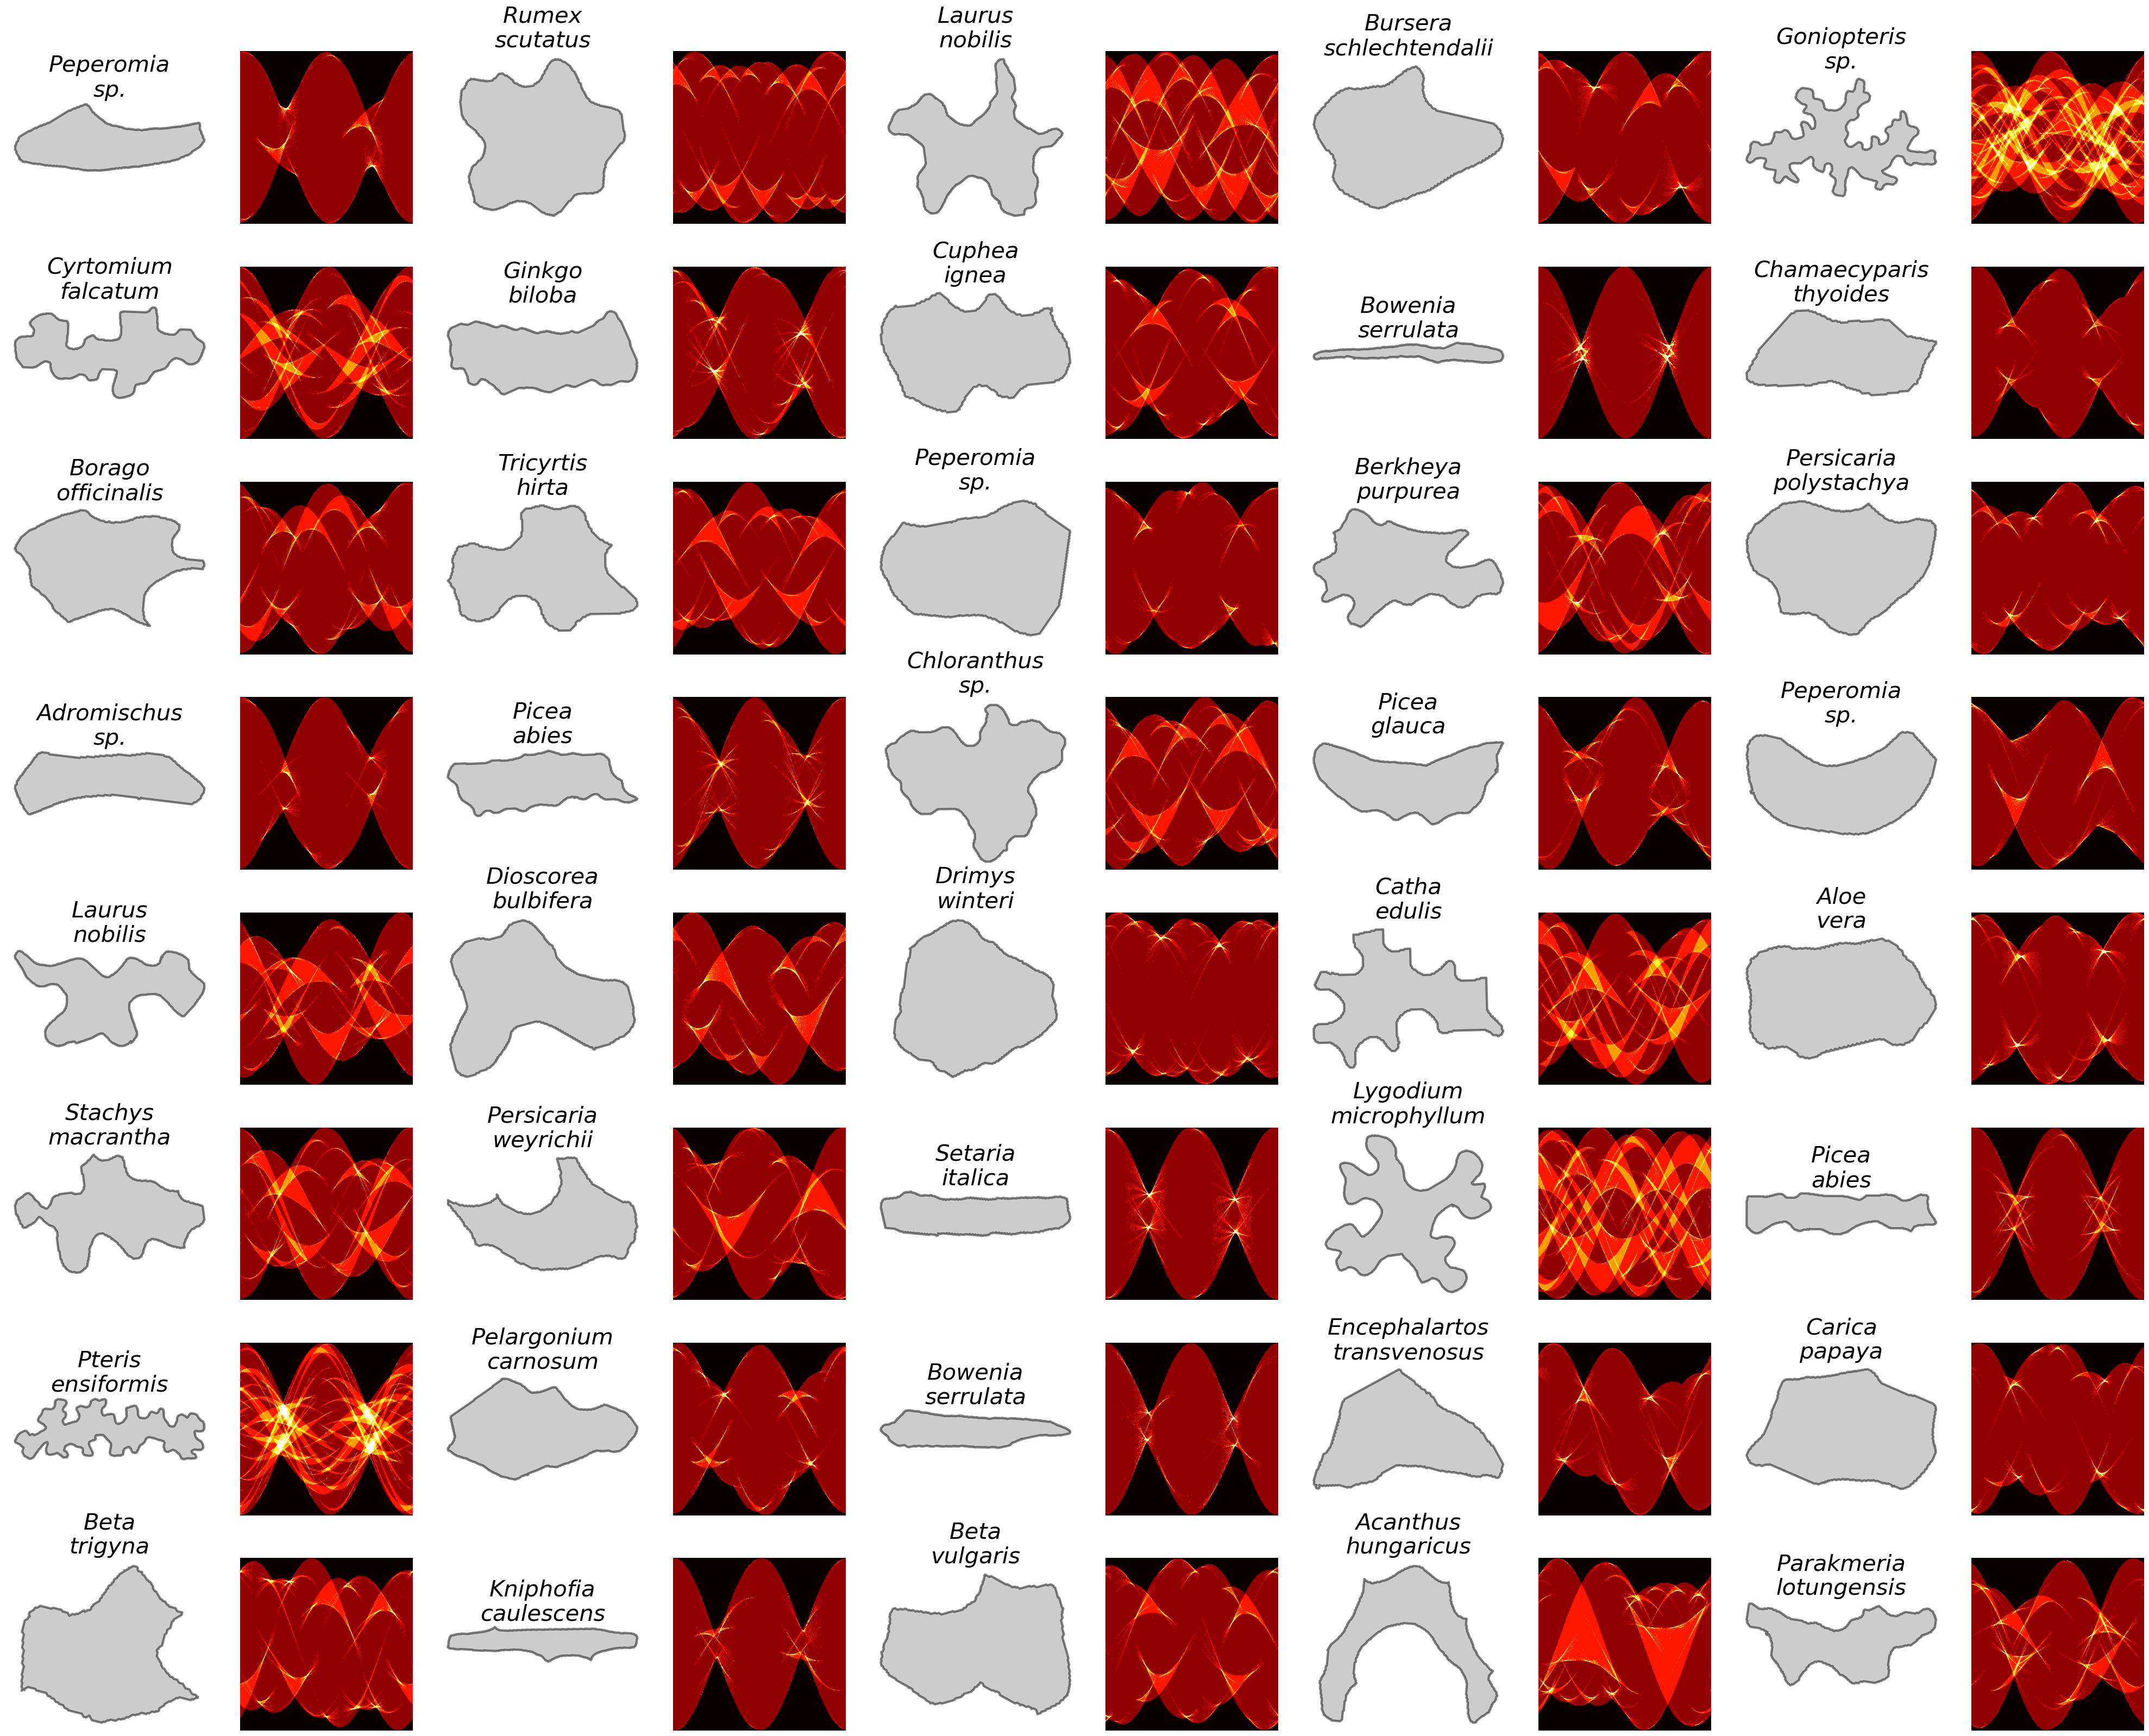

In [17]:
plot_count = 1 # counter for plt.subplot
ect_count = 0 # counter for ECT index
plt.figure(figsize=(40,32))

for i in range(len(rand_df)): # for each of the randomly chosen cells
    
    plt.subplot(8,10,plot_count)

    curr_file = "./CellCoordinates/"+str(rand_df["Sample_Number"].iloc[i])+".txt" # get current file
    curr_cell = np.loadtxt(curr_file, skiprows=1) # load current cell
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(curr_cell) # fit PCA to cell data to find longest axis
    pca_scores = pca.transform(curr_cell) # retrieve PCA scores of cell
    plt.plot(pca_scores[:,0], pca_scores[:,1], lw=3, c="k", alpha=0.5)
    plt.fill(pca_scores[:,0], pca_scores[:,1], lw=0, c="k", alpha=0.2)
    plt.title(cell_names[ect_count][:cell_names[ect_count].index(" ")] + "\n" + cell_names[ect_count][cell_names[ect_count].index(" ")+1:], 
              fontsize=30, fontstyle="italic")
    plt.axis("off")
    plt.gca().set_aspect("equal")
    
    plot_count+=1
    
    plt.subplot(8,10,plot_count)

    colormap =plt.cm.hot
    normalize = matplotlib.colors.Normalize(vmin=0, vmax=5)

    plt.imshow(ect_cell_arr[ect_count].T, cmap=colormap, norm=normalize)
    plt.axis("off")
    plt.gca().set_aspect("equal")

    ect_count+=1
    
    plot_count+=1
    
plt.tight_layout()